In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.stats import linregress

# Path to CSV file
spreadspoke_scores_file = "../CSV_Files/spreadspoke_scores.csv"
nfl_teams_file = "../CSV_Files/nfl_teams.csv"
# Read CSV file into DataFrame
spreadspoke_scores_df = pd.read_csv(spreadspoke_scores_file)
nfl_teams_df = pd.read_csv(nfl_teams_file)

# Data inspection
spreadspoke_scores_df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13796,1/21/2024,2023,Division,True,Buffalo Bills,24,27,Kansas City Chiefs,BUF,-2.5,46,Highmark Stadium,False,25.0,11.0,67.0,NaN
13797,1/21/2024,2023,Division,True,Detroit Lions,31,23,Tampa Bay Buccaneers,DET,-6.0,49.5,Ford Field,False,72.0,0.0,NaN,indoor
13798,1/28/2024,2023,Conference,True,Baltimore Ravens,10,17,Kansas City Chiefs,BAL,-4.5,44,M&T Bank Stadium,False,47.0,7.0,83.0,NaN
13799,1/28/2024,2023,Conference,True,San Francisco 49ers,34,31,Detroit Lions,SF,-7.5,53.5,Levi's Stadium,False,69.0,5.0,55.0,NaN


In [2]:
# Change Abbreviation with Old Abbreviation to Recent Abbreviation
nfl_teams_df['Abbreviation'] = nfl_teams_df['Abbreviation'].replace('LV', 'LVR')
spreadspoke_scores_df['team_favorite_id'] = spreadspoke_scores_df['team_favorite_id'].replace('LV', 'LVR')

# Data cleaning and filtering
# nfl_teams_clean_df = nfl_teams_df.drop(columns=['Conference', 'Division'])
last_5_years_df = spreadspoke_scores_df[spreadspoke_scores_df['schedule_season'] >= 2019]
clean_df = last_5_years_df.drop(columns=['stadium', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
                              'weather_humidity', 'weather_detail', 'spread_favorite', 'over_under_line'])
clean_df


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id
12411,9/5/2019,2019,1,False,Chicago Bears,3,10,Green Bay Packers,CHI
12412,9/8/2019,2019,1,False,Arizona Cardinals,27,27,Detroit Lions,DET
12413,9/8/2019,2019,1,False,Carolina Panthers,27,30,Los Angeles Rams,LAR
12414,9/8/2019,2019,1,False,Cleveland Browns,13,43,Tennessee Titans,CLE
12415,9/8/2019,2019,1,False,Dallas Cowboys,35,17,New York Giants,DAL
...,...,...,...,...,...,...,...,...,...
13796,1/21/2024,2023,Division,True,Buffalo Bills,24,27,Kansas City Chiefs,BUF
13797,1/21/2024,2023,Division,True,Detroit Lions,31,23,Tampa Bay Buccaneers,DET
13798,1/28/2024,2023,Conference,True,Baltimore Ravens,10,17,Kansas City Chiefs,BAL
13799,1/28/2024,2023,Conference,True,San Francisco 49ers,34,31,Detroit Lions,SF


In [3]:
# Count of favorite team appearances
team_favorite_count = clean_df["team_favorite_id"].value_counts()
team_favorite_count_df = team_favorite_count.reset_index()
team_favorite_count_df.columns = ['Abbreviation', 'Favorite Pick Count']
team_favorite_count_df

,Abbreviation,Favorite Pick Count
0,KC,87
1,SF,73
2,BUF,69
3,BAL,66
4,DAL,62
5,TB,60
6,GB,59
7,PHI,58
8,LAR,55
9,NO,54


In [4]:
# Save Graph Images to Directed Folder
save_dir = "../Images"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

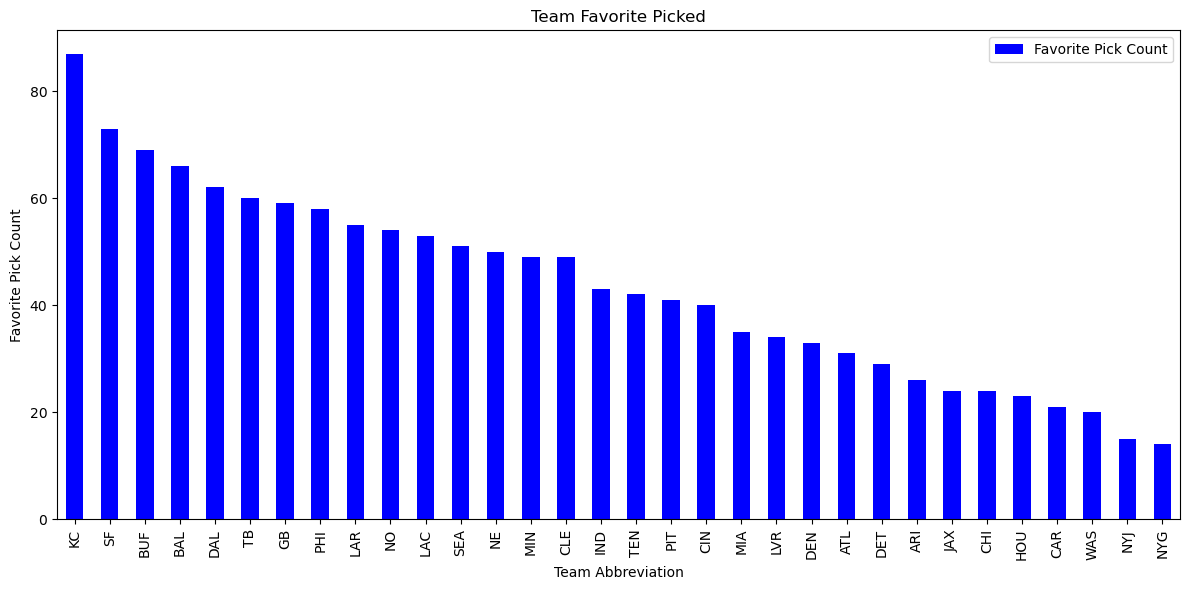

In [5]:
# Generate Bar Graph
team_favorite_count_df.plot(kind='bar', x='Abbreviation', y='Favorite Pick Count', color='blue', figsize=(12, 6))

# Labeling x-axis and y-axis
plt.title("Team Favorite Picked")
plt.xlabel('Team Abbreviation')
plt.ylabel('Favorite Pick Count')

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Team Favorite Picked.png'))
plt.show()

In [6]:
# Count of favorite team appearances

favorite_wins = clean_df[clean_df["score_home"] > clean_df["score_away"]]["team_favorite_id"].value_counts()
favorite_wins_df = favorite_wins.reset_index()
favorite_wins_df.columns = ['Abbreviation', 'Win Count']
favorite_wins_df

,Abbreviation,Win Count
0,KC,48
1,BUF,41
2,GB,38
3,SF,37
4,DAL,36
5,PHI,34
6,BAL,33
7,CLE,32
8,TB,29
9,LAR,29


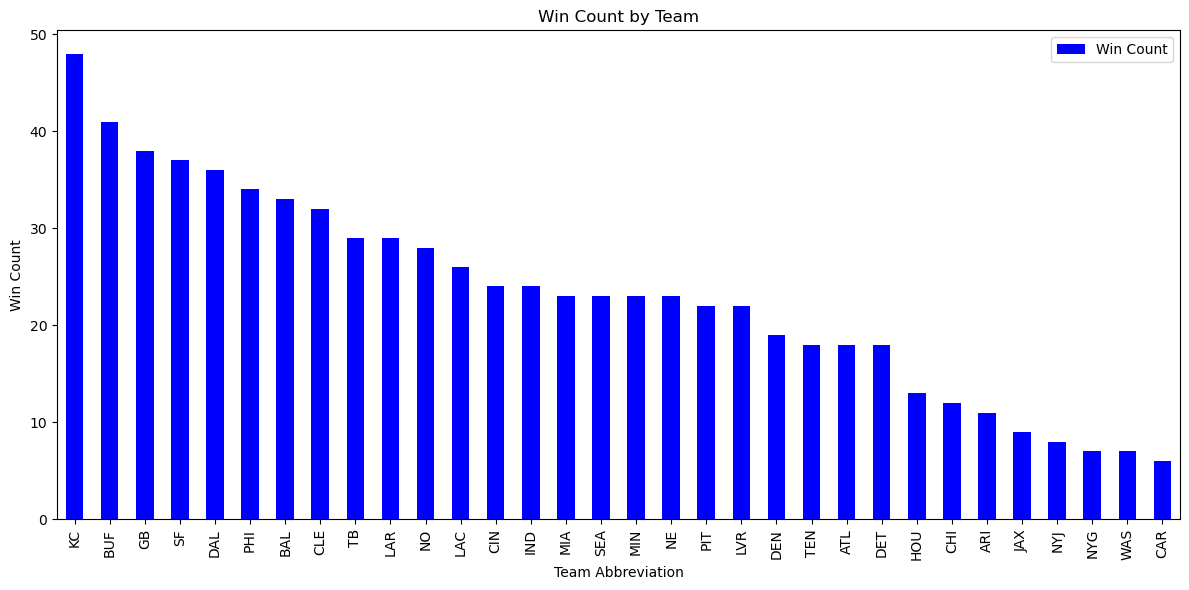

In [7]:
# Create Graph
favorite_wins_df.plot(kind='bar', x='Abbreviation', y='Win Count', color='blue', figsize=(12, 6))

# Labeling Title and labels
plt.title('Win Count by Team')
plt.xlabel('Team Abbreviation')
plt.ylabel('Win Count')

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'win_count_by_team.png'))
plt.show()

In [8]:
# Pie Graph for Win Count
"""
# Graph preparation
plt.figure(figsize=(8, 8))

# Assign data
labels = merged_df['Abbreviation']
sizes = merged_df['Win Count']

# Define explode values for each section
explode = [0.1] * len(labels)  # Adjust the values as per your preference

# Draw pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)

# Add title
plt.title('Win Count by Team')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'win_count_pie_chart.png'))
plt.show()
"""

"\n# Graph preparation\nplt.figure(figsize=(8, 8))\n\n# Assign data\nlabels = merged_df['Abbreviation']\nsizes = merged_df['Win Count']\n\n# Define explode values for each section\nexplode = [0.1] * len(labels)  # Adjust the values as per your preference\n\n# Draw pie chart\nplt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)\n\n# Add title\nplt.title('Win Count by Team')\n\n# Equal aspect ratio ensures that pie is drawn as a circle\nplt.axis('equal')\n\n# Save plot\nplt.tight_layout()\nplt.savefig(os.path.join(save_dir, 'win_count_pie_chart.png'))\nplt.show()\n"

In [9]:
# Merge Dateframes
merged_f_t = pd.merge(favorite_wins_df, team_favorite_count_df, on='Abbreviation')
merged_df = pd.merge(merged_f_t, nfl_teams_df, on='Abbreviation')


In [10]:
# Create List for Value of 'Favorite Pick' and 'Win Count'
favorite_picks = []
win_rates = []

# Each Team Favorite Pick Calculation and add to merged_df
for index, row in merged_df.iterrows():
    favorite_pick = row['Win Count'] + (row['Favorite Pick Count'] - row['Win Count'])
    favorite_picks.append(favorite_pick)
merged_df['Favorite Pick'] = favorite_picks

# Each Team 'Win Count' Calculation and add to merged_df
for index, row in merged_df.iterrows():
    win_rate = row['Win Count'] / row['Favorite Pick Count'] * 100
    win_rates.append(round(win_rate, 2))
merged_df['Win Rate'] = win_rates

In [11]:
# Reindex column
new_column_order = ['Name', 'Abbreviation', 'Win Count', 'Favorite Pick', 'Win Rate']
win_rate = merged_df.reindex(columns=new_column_order)
win_rate

,Name,Abbreviation,Win Count,Favorite Pick,Win Rate
0,Kansas City Chiefs,KC,48,87,55.17
1,Buffalo Bills,BUF,41,69,59.42
2,Green Bay Packers,GB,38,59,64.41
3,San Francisco 49ers,SF,37,73,50.68
4,Dallas Cowboys,DAL,36,62,58.06
5,Philadelphia Eagles,PHI,34,58,58.62
6,Baltimore Ravens,BAL,33,66,50.00
7,Cleveland Browns,CLE,32,49,65.31
8,Tampa Bay Buccaneers,TB,29,60,48.33
9,Los Angeles Rams,LAR,29,55,52.73


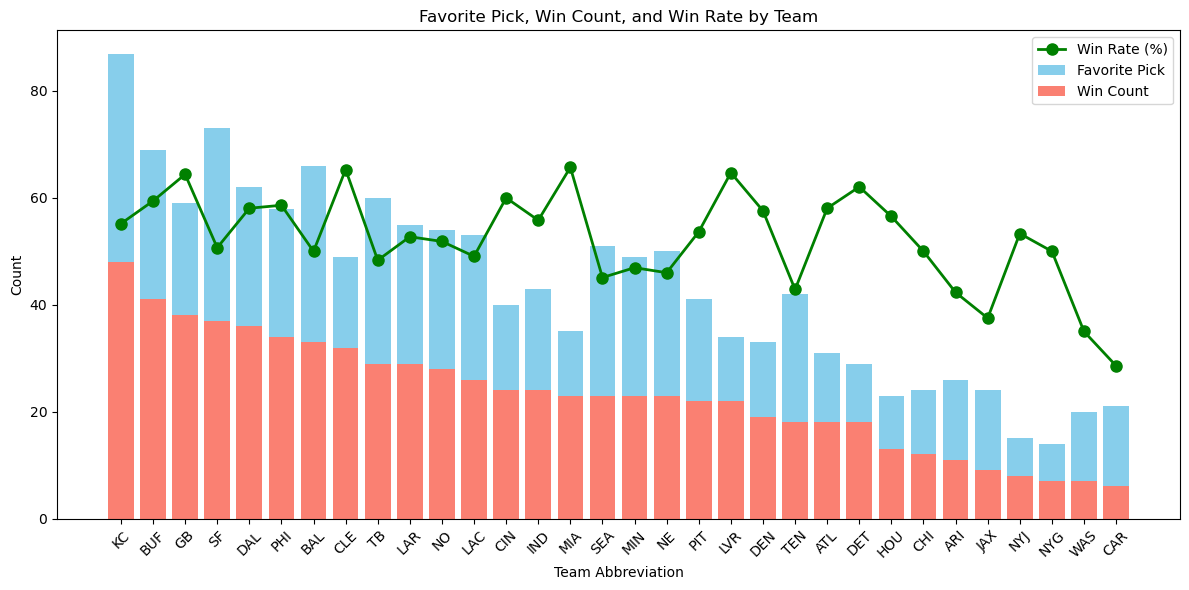

In [12]:
# Graph preparation
plt.figure(figsize=(12, 6))

# Assign data to x and y axes
x = merged_df['Abbreviation']
y1 = merged_df['Favorite Pick']
y2 = merged_df['Win Count']
y3 = merged_df['Win Rate']

# Draw bar plot
plt.bar(x, y1, color='skyblue', label='Favorite Pick')
plt.bar(x, y2, color='salmon', label='Win Count')
plt.plot(x, y3, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Win Rate (%)')

# Add title and axis labels
plt.title('Favorite Pick, Win Count, and Win Rate by Team')
plt.xlabel('Team Abbreviation')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'bar_plot_team_stats.png'))
plt.show()


In [13]:
# Calculate Moneyline
def calculate_moneyline(win_rate):
    return 100 / win_rate
Moneyline_df = win_rate
# Add Moneyline to Dataframe
Moneyline_df['Moneyline'] = Moneyline_df['Win Rate'].apply(calculate_moneyline)

# Result
Moneyline_df

,Name,Abbreviation,Win Count,Favorite Pick,Win Rate,Moneyline
0,Kansas City Chiefs,KC,48,87,55.17,1.812579
1,Buffalo Bills,BUF,41,69,59.42,1.682935
2,Green Bay Packers,GB,38,59,64.41,1.552554
3,San Francisco 49ers,SF,37,73,50.68,1.973165
4,Dallas Cowboys,DAL,36,62,58.06,1.722356
5,Philadelphia Eagles,PHI,34,58,58.62,1.705902
6,Baltimore Ravens,BAL,33,66,50.00,2.000000
7,Cleveland Browns,CLE,32,49,65.31,1.531159
8,Tampa Bay Buccaneers,TB,29,60,48.33,2.069108
9,Los Angeles Rams,LAR,29,55,52.73,1.896454


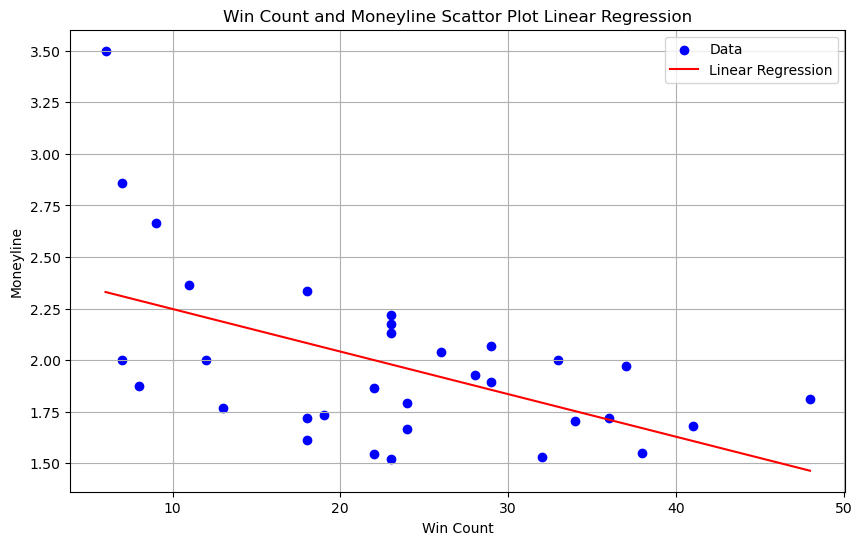

Win Count and Moneyline Correlation: -0.5313830316690429


In [14]:
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(Moneyline_df['Win Count'], Moneyline_df['Moneyline'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Moneyline_df['Win Count'], Moneyline_df['Moneyline'], color='blue', label='Data')

# Plot linear regression line
plt.plot(Moneyline_df['Win Count'], intercept + slope * Moneyline_df['Win Count'], color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel('Win Count')
plt.ylabel('Moneyline')
plt.title('Win Count and Moneyline Scattor Plot Linear Regression')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# correlation between Moneyline and Win Count
correlation = Moneyline_df['Win Count'].corr(Moneyline_df['Moneyline'])
print("Win Count and Moneyline Correlation:", correlation)


- Negative correlation between Win Count and Moneyline with a correlation coefficient of '-0.5313830316690429' on Win Count and Moneyline Scattor Plot Linear Regression.

In [15]:
# Scatter plot with linear regression for Win Count and Moneyline
plt.figure(figsize=(10, 6))
plt.scatter(Moneyline_df['Win Count'], Moneyline_df['Moneyline'], color='green', label='Data')
plt.plot(Moneyline_df['Win Count'], intercept + slope * Moneyline_df['Win Count'], color='red', label='Linear Regression')
plt.xlabel('Win Count')
plt.ylabel('Moneyline')
plt.title('Scatter Plot with Linear Regression (Win Count vs Moneyline)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'scatter_plot_win_count_vs_moneyline.png'))
plt.close()

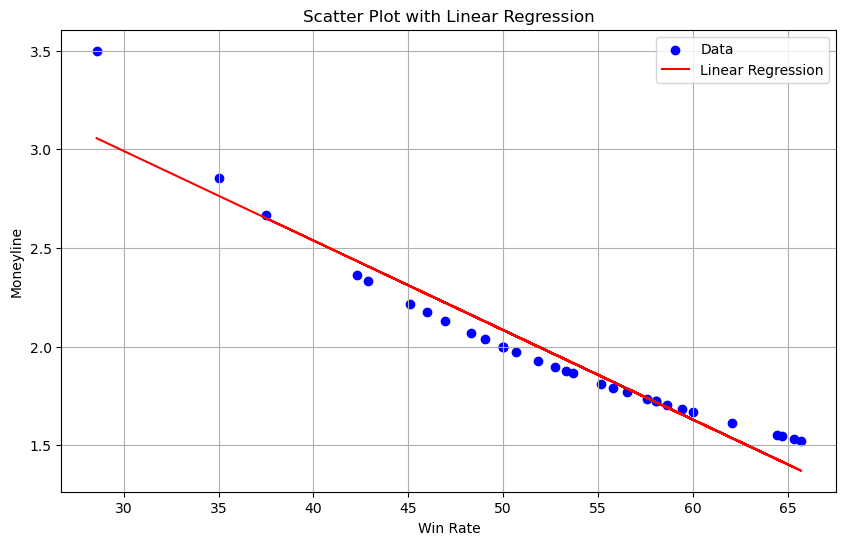

Correlation between Win Rate and Moneyline: -0.9641634063264927


In [16]:
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(Moneyline_df['Win Rate'], Moneyline_df['Moneyline'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Moneyline_df['Win Rate'], Moneyline_df['Moneyline'], color='blue', label='Data')

# Plot linear regression line
plt.plot(Moneyline_df['Win Rate'], intercept + slope * Moneyline_df['Win Rate'], color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel('Win Rate')
plt.ylabel('Moneyline')
plt.title('Scatter Plot with Linear Regression')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
# Save Image
save_dir = "../Images"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, 'scatter_plot_with_linear_regression.png'))
plt.close()


# Calculate correlation
correlation = Moneyline_df['Win Rate'].corr(Moneyline_df['Moneyline'])
print("Correlation between Win Rate and Moneyline:", correlation)



 - Negative correlation between Win Rate and Moneyline with a correlation coefficient of '-0.9641634063264927' on Win Rate and Moneyline Scattor Plot Linear Regression.

In [17]:
# Scatter plot with linear regression
plt.figure(figsize=(10, 6))
plt.scatter(Moneyline_df['Win Rate'], Moneyline_df['Moneyline'], color='blue', label='Data')
plt.plot(Moneyline_df['Win Rate'], intercept + slope * Moneyline_df['Win Rate'], color='red', label='Linear Regression')
plt.xlabel('Win Rate')
plt.ylabel('Moneyline')
plt.title('Scatter Plot with Linear Regression')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'scatter_plot_with_linear_regression.png'))
plt.close()